In [14]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [15]:
data = ares.analysis.GalaxyPopulation() #for lit values

In [16]:
# Independent variables
# redshifts = np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75])
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

# redshifts = np.array([0.35, 0.875, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9])

Ms = np.linspace(7, 12, 60)

# print(Ms)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('logbins', Ms)]
blob_f1 = ['StellarMassFunction']

In [17]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [18]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)

# print(base_pars)
# This is important!
# base_pars['pop_calib_lum'] = None

In [19]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]', 
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(-1, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')

In [20]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
# logM_0 = 11.0 #(0.01)

mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\analysis\GalaxyPopulation.py:1259: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


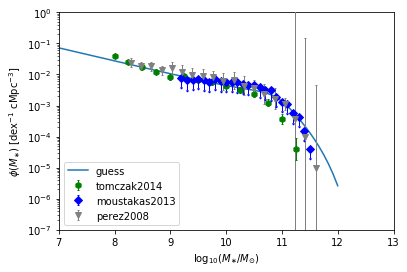

In [21]:
# base_pars
# Ms = np.logspace(7, 12, 60)

base_pars.update(guesses)
pop = ares.populations.GalaxyPopulation(**base_pars)

z = 0.35

smf = pop.StellarMassFunction(z, Ms)

pl.semilogy(Ms, smf, label='guess')
data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.legend()
pl.show()

In [22]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

# print(fitter_smf.xdata)

In [23]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [24]:
# print(fitter.blob_names)
# print(fitter.blob_ivars)
# print(fitter.blob_funcs, fitter.blob_kwargs)


In [25]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 30

fitter.jitter = [0.1] * len(fitter.parameters)
# fitter.jitter = [0.01, 0.01, 0.001, 0.005, 0.01, 0.01, 0.04, 0.01]

fitter.guesses = guesses
# fitter.debug('True')
# fitter.pops
# nwalkers

# Fixing position of walker 5 (parameter pq_func_par0[1])
# Moved from -0.1599342738763654 to 0.0013585858154658292
# Fixing position of walker 12 (parameter pq_func_par0[1])
# Moved from -0.001417293276098991 to 0.0660835869701445
# Fixing position of walker 15 (parameter pq_func_par0[1])
# Moved from -0.04258399203807839 to 0.10476921952290041
# Fixing position of walker 18 (parameter pq_func_par0[1])
# Moved from -0.06296028237427881 to 0.17610467287301498
# Fixing position of walker 19 (parameter pq_func_par0[1])
# Moved from -0.0038325950098419513 to 0.06874849313267999
# Fixing position of walker 20 (parameter pq_func_par0[1])
# Moved from -0.028797350775409545 to 0.19188961299591725
# Fixing position of walker 26 (parameter pq_func_par0[1])
# Moved from -0.06516655636450407 to 0.024792598687231195
# Fixing position of walker 27 (parameter pq_func_par0[1])
# Moved from -0.15086064235646318 to 0.11671101395451511


In [26]:
# Run the thing
fitter.run('MCMC_files/smftest_cal', burn=5, steps=45, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Fri Jul 17 16:28:35 2020
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
# Wrote MCMC_files/smftest_cal.burn.dd0000.facc.pkl: Fri Jul 17 16:30:03 2020
# Wrote MCMC_files/smftest_cal.burn.dd0001.facc.pkl: Fri Jul 17 16:30:44 2020
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
# Wrote MCMC_files/smftest_cal.burn.dd0002.facc.pkl: Fri Jul 17 16:31:24 2020
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
Error, bin(s) out of interpolation bounds
# Wrote MCMC_files/smftest_cal.burn.dd0003.fa

In [4]:
# anl = ares.analysis.ModelSet('MCMC_files/smftest_cal1_07_08')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run5_07_08')
anl = ares.analysis.ModelSet('..\Cedar/test/test2')
# anl = ares.analysis.ModelSet('../Cedar/savedFits/smf_16_07_13-17_5.0')


labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels
# anl.custom_labels


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ..\Cedar/test/                                                                         ####
#### prefix      : test2                                                                                  ####
#### N-d         : 8                                                                                      ####


# Loading ..\Cedar/test/test2.dd*.chain.pkl...
# Loaded ..\Cedar/test/test2.dd*.chain.pkl in 0.017 s.
# Loaded ..\Cedar/test\test2.dd0000.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0001.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0002.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0003.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0004.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0005.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0006.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0007.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0008.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0009.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0010.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0011.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0012.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0013.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test2.dd0014.blob_2d.galaxy_smf.pkl
# Loaded ..\C

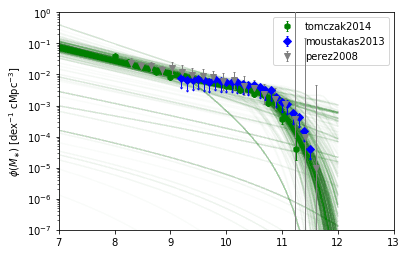

In [15]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.35
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='g', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.semilogy()

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [5]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

# Loading ..\Cedar/test/test2.dd*.chain.pkl...
# Loaded ..\Cedar/test/test2.dd*.chain.pkl in 0.028 s.
pq_func_par0[0]: 1.025820e+00
pq_func_par2[0]: 1.712514e-01
pq_func_par0[1]: 9.198359e-02
pq_func_par2[1]: -7.416468e-01
pq_func_par0[2]: 6.025543e-01
pq_func_par2[2]: -1.094610e-01
pq_func_par0[3]: 1.193625e+01
pq_func_par2[3]: 1.383002e-01


In [ ]:

trig = anl.TrianglePlot(pars=params)

In [ ]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [6]:
anl.max_likelihood_parameters()

1344
[[1344]
 [1345]
 [1424]
 [1425]
 [1504]
 [1505]
 [1584]
 [1585]]


{'pq_func_par0[0]': 1.9805869738399209,
 'pq_func_par2[0]': 0.3585396244333763,
 'pq_func_par0[1]': 0.7582992670519343,
 'pq_func_par2[1]': -0.7039796480521767,
 'pq_func_par0[2]': 0.8964715688420797,
 'pq_func_par2[2]': 0.9164094619138378,
 'pq_func_par0[3]': 13.254851784459127,
 'pq_func_par2[3]': 1.9712032290772254}

In [7]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.025820e+00
pq_func_par2[0]: 1.712514e-01
pq_func_par0[1]: 9.198359e-02
pq_func_par2[1]: -7.416468e-01
pq_func_par0[2]: 6.025543e-01
pq_func_par2[2]: -1.094610e-01
pq_func_par0[3]: 1.193625e+01
pq_func_par2[3]: 1.383002e-01


In [8]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [9]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

1344
[[1344]
 [1345]
 [1424]
 [1425]
 [1504]
 [1505]
 [1584]
 [1585]]
(1.9805869738399209, array([-0.89953814,  1.02851021]))
(0.3585396244333763, array([-0.11174691,  0.28792067]))
(0.7582992670519343, array([-0.5440315 ,  0.74078436]))
(-0.7039796480521767, array([0.05285511, 0.12260774]))
(0.8964715688420797, array([-0.24065363,  0.35568261]))
(0.9164094619138378, array([-0.99174552,  1.10841759]))
(13.254851784459127, array([-1.29705311,  1.4242813 ]))
(1.9712032290772254, array([-1.70242723,  1.96130317]))


In [10]:
pars_best = ares.util.ParameterBundle("emma:model1")

# print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
[1.00214881e-239 1.08896150e-239 1.18329448e-239 ... 2.54173171e-189
 2.76191316e-189 3.00116818e-189]
SM range is way too small!
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
Error, bin(s) out of interpolation bounds
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf

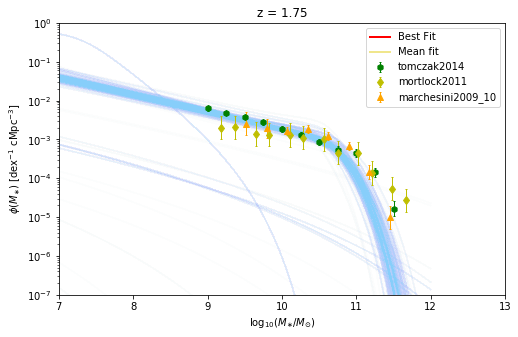

In [13]:
z = 1.75

Ms = np.logspace(7, 13, 80)

# print(Ms)
fig, ax = pl.subplots(figsize=(8, 5))

ls_best = pop_best.StellarMassFunction(z, Ms)

print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms)
print(ls_mean)


ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples=1000, color='lightskyblue', alpha=0.01, ax=ax)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, ax=ax, round_z=0.2, log10Mass=True)

ax.semilogy(Ms, ls_best, label='Best Fit', color="red", linewidth=2)
pl.semilogy(Ms, ls_mean, label='Mean fit', color="khaki", linewidth=2)

pl.title("z = %.2f" %z)
ax.set_xlabel('log$_{10}(M_{\\ast} / M_{\odot})$')
pl.legend()
# pl.ylim(1e-18, 1e2)
pl.show()

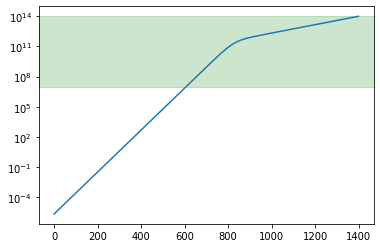

In [20]:
#looking at good stellar mass range

pl.axhspan(1e7, 1e14, alpha=0.2, color='green')

# pl.semilogy(pop_best.SMHM(1.75))
pl.semilogy(pop_mean.SMHM(0.35))

pl.show()

In [28]:
ls_mean = pop_mean.StellarMassFunction(z, Ms)

pop_mean.SMHM(1)
print(ls_mean)

Error, bin(s) out of interpolation bounds
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]


1125.7852589148997
[915.5373826065409 921.8640164626569 937.5764217536272 937.5764217536272
 786.2009415969949 834.9483369029597 948.4363587786646 948.4363587786646
 -1700.9637026941393 -1700.9637026941393 1125.7852589148997
 1125.7852589148997 825.6566635995702 825.6566635995702 919.7384214640506
 923.1233795282117 910.1331834805949 910.1331834805949 -1429.008846784748
 -1429.008846784748]


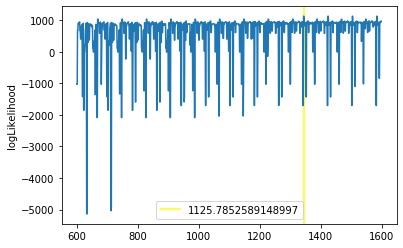

In [12]:
ticks = np.linspace(0, len(anl.logL)-1, len(anl.logL))

xstart = 600

maxL = anl.logL[1344]

print(anl.logL[1344])
print(anl.logL[1344-10:1344+10])

pl.axvline(x=1344, color="yellow", label=str(maxL))

pl.plot(ticks[xstart:], anl.logL[xstart:])
# pl.plot(ticks, anl.logL)
pl.ylabel("logLikelihood")

# pl.ylim(-500,)
pl.legend()
pl.show()